In [8]:
#!pip install cohere openai
#!pip install -U numpy umap-learn
#!pip install -U tensorflow_probability

In [1]:
import cohere
from datasets import load_dataset,load_from_disk,Dataset,concatenate_datasets
import os
import numpy as np
import umap
from collections import Counter
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torch
from sentence_transformers import util
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
if not os.path.exists("dataset"):
    dataset = load_dataset("rjac/all-the-news-2-1-Component-one-embedding",split="train")
    dataset.save_to_disk("dataset")

In [3]:
dataset = load_from_disk("dataset")
dataset.set_format(type='numpy', columns=['embedding',"paragraph"],output_all_columns=True)
embedding = dataset["embedding"]

# Embedding

The embedding was generated using the [`SBert`](https://arxiv.org/abs/1901.09321) model. in which we want to do some clustering of the embeddings. for that we will generate a UMAP embedding.



In [4]:
from umap.parametric_umap import ParametricUMAP
reducer = ParametricUMAP(n_components=2,low_memory=True,n_epochs=5)
reducer = reducer.fit(embedding[np.random.choice(embedding.shape[0],1_000_000,replace=False)])

2022-08-05 22:06:28.142427: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 182175840 exceeds 10% of free system memory.
2022-08-05 22:06:29.013259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 182175840 exceeds 10% of free system memory.
2022-08-05 22:06:29.178495: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 182175840 exceeds 10% of free system memory.
2022-08-05 22:06:29.304228: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 182175840 exceeds 10% of free system memory.
2022-08-05 22:06:29.641751: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 90916976 exceeds 10% of free system memory.


Epoch 1/10
2277/2277 [==============================] - 19s 7ms/step - loss: 0.2264
Epoch 2/10
2277/2277 [==============================] - 15s 7ms/step - loss: 0.1793
Epoch 3/10
2277/2277 [==============================] - 15s 7ms/step - loss: 0.1702
Epoch 4/10
2277/2277 [==============================] - 14s 6ms/step - loss: 0.1659
Epoch 5/10
2277/2277 [==============================] - 15s 7ms/step - loss: 0.1629
Epoch 6/10
2277/2277 [==============================] - 14s 6ms/step - loss: 0.1609
Epoch 7/10
2277/2277 [==============================] - 15s 7ms/step - loss: 0.1593
Epoch 8/10
2277/2277 [==============================] - 15s 6ms/step - loss: 0.1578
Epoch 9/10
2277/2277 [==============================] - 15s 7ms/step - loss: 0.1570
Epoch 10/10
2277/2277 [==============================] - 15s 6ms/step - loss: 0.1558


In [5]:
# randomly select 1_000 samples from embedding
sample_embedding = embedding[np.random.choice(embedding.shape[0],350_000,replace=False)]
umap_embeds = reducer.transform(sample_embedding)

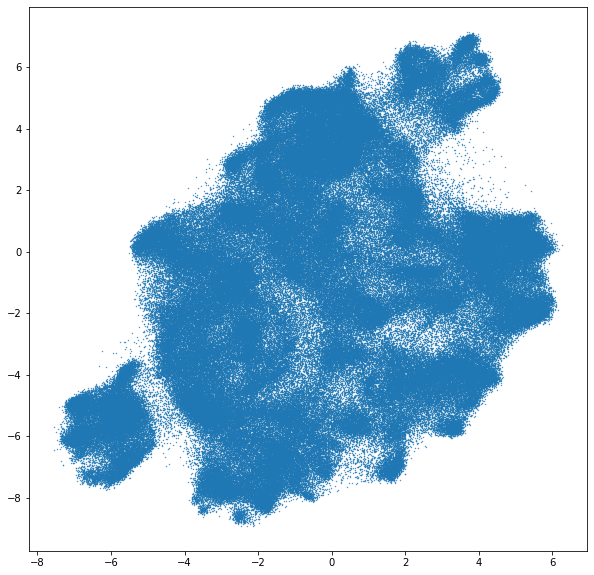

In [6]:
# plot the embeddings x and y (figure of size 20x20)
plt.figure(figsize=(10,10))
plt.scatter(umap_embeds[:,0],umap_embeds[:,1],s=0.15)

# Clustering Model

Given the above graph we can see that using embeddings we can cluster the data in about 10 to 17 clusters. For the Kmean models we will use the 2.7 MM embedding to find the centroids associated with the clusters.

In [21]:
k = 36
kmean_model = MiniBatchKMeans(n_clusters = k, max_iter = 10_000,n_init=20, batch_size= 256 * os.cpu_count() - 5 ,random_state = 654).fit(embedding)

In [41]:
distances = kmean_model.transform(sample_embedding)
cluster = kmean_model.predict(sample_embedding)
cluster_distances = np.min(distances,axis=1)
sample_cluster_filtered = [c if d < 0.9 else k+1 for c,d in zip(cluster,cluster_distances)]

In [42]:
#sample_cluster = kmean_model.predict(sample_embedding)
sample_cluster_df = pd.DataFrame(umap_embeds)
sample_cluster_df.columns = ["x","y"]
sample_cluster_df["cluster"] = sample_cluster_filtered

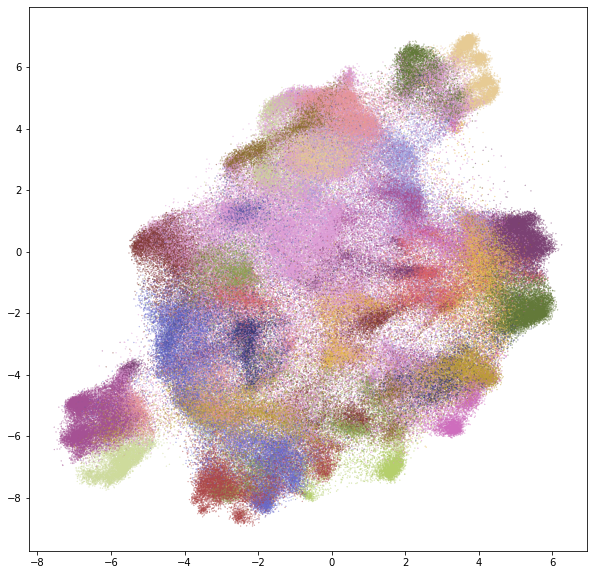

In [48]:
# plot the embeddings x and y (figure of size 20x20) with cluster labels
# exclude the cluster k+1
plt.figure(figsize=(10,10))
plt.scatter(sample_cluster_df["x"],sample_cluster_df["y"],s=0.05,c=sample_cluster_df["cluster"],cmap="tab20b")
plt.show()

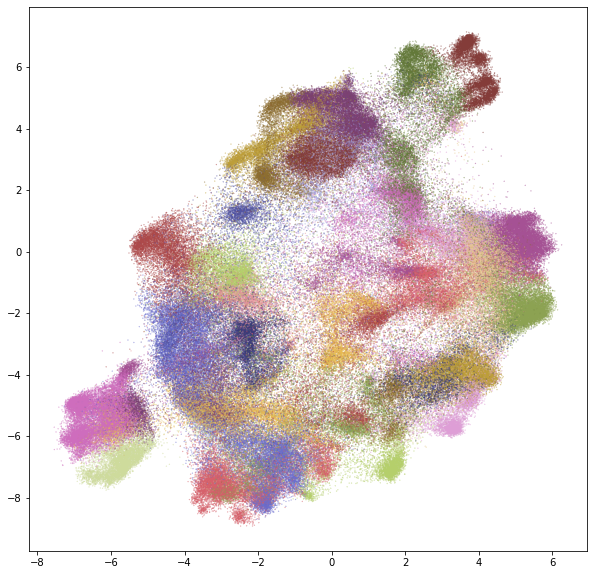

In [46]:
# plot the embeddings x and y (figure of size 20x20) with cluster labels
# exclude the cluster k+1
plt.figure(figsize=(10,10))
plt.scatter(sample_cluster_df[sample_cluster_df["cluster"] != k+1]["x"],sample_cluster_df[sample_cluster_df["cluster"] != k+1]["y"],s=0.05,c=sample_cluster_df[sample_cluster_df["cluster"] != k+1]["cluster"],cmap="tab20b")
plt.show()

13


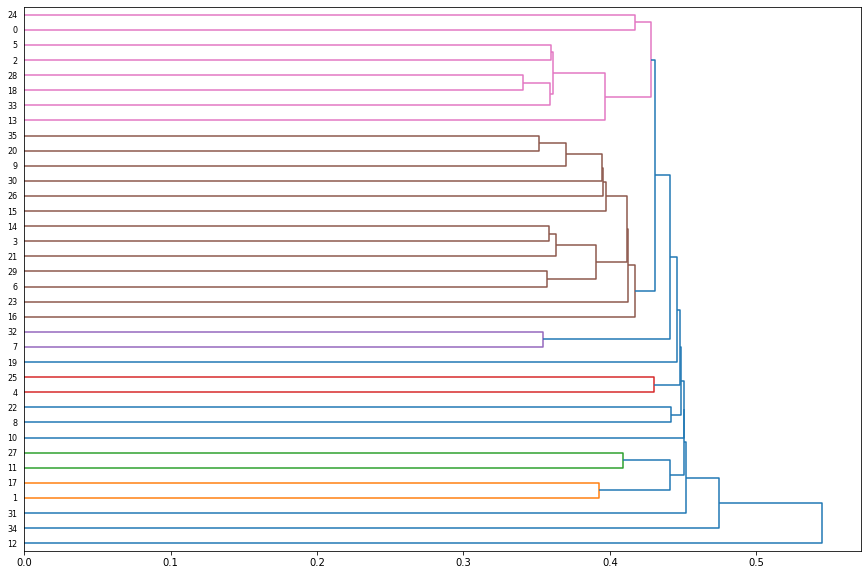

In [51]:
threshold = 0.43
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 10
hierarchy_cluster = hierarchy.linkage(kmean_model.cluster_centers_, 'single')
dn = hierarchy.dendrogram(hierarchy_cluster, orientation='right',color_threshold=threshold)
reduced_cluster = hierarchy.fcluster(hierarchy_cluster, threshold,criterion='distance')
hierarchy_cluster_label = {c:i for c,i in zip(np.unique(kmean_model.labels_),reduced_cluster)}
print(len(np.unique(reduced_cluster)))

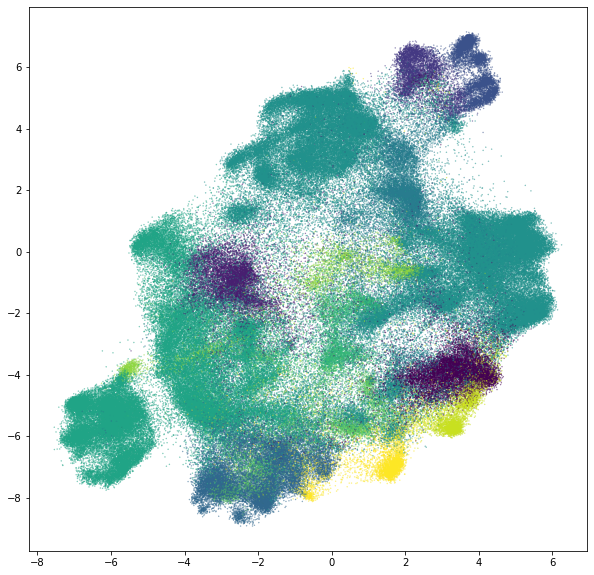

In [52]:
# plot the embeddings x and y (figure of size 20x20), show legend
plt.figure(figsize=(10,10))
plt.scatter(umap_embeds[:,0],umap_embeds[:,1],s=0.15,c=[hierarchy_cluster_label.get(c) for c in sample_cluster_filtered],alpha=0.7)
plt.show()


In [53]:
distances = kmean_model.transform(embedding)
cluster = kmean_model.predict(embedding)
cluster_distances = np.min(distances,axis=1)
cluster_filtered = cluster

In [55]:
hierarchy_cluster_label.get(k+1,-1)

-1

In [56]:
hierarchy_cluster_label = [hierarchy_cluster_label.get(c,-1) for c in cluster_filtered]

df_clusters = pd.DataFrame({"cluster":cluster_filtered,"hierarchy": hierarchy_cluster_label})
df_clusters = Dataset.from_pandas(df_clusters)

clustered_subset = concatenate_datasets([dataset,df_clusters],axis=1)
clustered_subset = clustered_subset.remove_columns(['article_idx', 'year', 'month', 'paragraph_position', 'embedding'])

In [57]:
clustered_subset.save_to_disk("clustered_subset")

In [58]:
embedding = None
reducer = None
umap_embeds = None
distances = None

In [59]:
import joblib

In [60]:
# save the model
joblib.dump(kmean_model, 'kmean_model.pkl')

['kmean_model.pkl']

# Topic Modeling

In [58]:
clustered_subset = load_from_disk("clustered_subset")

In [61]:
clustered_subset

Dataset({
    features: ['paragraph', 'cluster', 'hierarchy'],
    num_rows: 2475520
})

In [59]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(pos):
    if pos[0] == 'N':
        return wordnet.NOUN
    elif pos[0] == 'V':
        return wordnet.VERB
    elif pos[0] == 'J':
        return wordnet.ADJ
    elif pos[0] == 'R':
        return wordnet.ADV
    else:
        return wordnet.NOUN

def get_pos_tag(text):
    """Apply lemmantization to the text depending on the part of speech tag, lowercase the text and remove stopwords/punctuation 
    Args:
        text (str): text to be lemmantized
    Returns:
        str: lemmantized text
    
    """
    pos_tag = nltk.pos_tag(nltk.word_tokenize(text))
    pos_tag = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tag]
    # lowercase all the words
    pos_tag = [word.lower() for word in pos_tag]
    # remove stopwords
    pos_tag = [word for word in pos_tag if word not in stopwords.words('english')]
    # remove punctuation
    pos_tag = [word for word in pos_tag if re.search('[a-zA-Z]', word)]
    return pos_tag



In [64]:
def apply_preprocess(batch):
    clean_text = [get_pos_tag(p) for p in batch["paragraph"]]
    return {"paragraph": clean_text}

In [65]:
clustered_subset = clustered_subset.map(apply_preprocess,batched=True,num_proc=8)

#3:   0%|          | 0/310 [00:00<?, ?ba/s]

#0:   0%|          | 0/310 [00:00<?, ?ba/s]

#1:   0%|          | 0/310 [00:00<?, ?ba/s]

#4:   0%|          | 0/310 [00:00<?, ?ba/s]

#2:   0%|          | 0/310 [00:00<?, ?ba/s]

#6:   0%|          | 0/310 [00:00<?, ?ba/s]

#5:   0%|          | 0/310 [00:00<?, ?ba/s]

#7:   0%|          | 0/310 [00:00<?, ?ba/s]

KeyboardInterrupt: 

In [ ]:
all_df = clustered_subset.to_pandas()

In [54]:
# iterate a list in batches of 50
import itertools
def batch_iter(iterable, batch_size):
    iterator = iter(iterable)
    for first in iterator:
        yield itertools.chain([first], itertools.islice(iterator, batch_size - 1))

In [55]:
word_frequency = Counter()
for batch in batch_iter(all_df["paragraph"],10_000):
    word_frequency.update([w for p in list(batch) for w in get_pos_tag(p)])

KeyboardInterrupt: 

In [27]:
k = 36
print("-------------------------------------------------------------------")
cluster_labels = {}
for c, df in all_df.groupby("cluster"):
    if c != k+1:
        term_frequency = Counter()
        for batch in batch_iter(df["paragraph"],10_000):
            term_frequency.update([w for p in list(batch) for w in get_pos_tag(p)])

        average_word_per_cluster = sum(term_frequency.values())/len(term_frequency.values())
        c_idf = {w: np.log(1+(average_word_per_cluster/f)) for w,f in word_frequency.items()}
        cTF_IDF = pd.DataFrame.from_dict({w:tf*c_idf.get(w,0) for w,tf in term_frequency.items()},orient="index")
        top50 = cTF_IDF.sort_values(by=0,ascending=False).head(50).reset_index()["index"].values
        labels = ' , '.join(top50)
        print(labels)
        cluster_labels[c] = labels
        print("------------------------------------------------------------------- {}".format(c))

-------------------------------------------------------------------
barnier , dup , dijsselbloem , baczynska; , dombrovskis , fianna , eu27 , coveney , esm , brexiteers , fdp , schaeuble , eurosceptics , spd’s , baczynska, , eu-uk , pro-eu , backstop, , passporting , eurogroup
------------------------------------------------------------------- 0
h-shares. , h-shares , blanchard; , chinext , self-ruled , h-share , yawen , yao; , ruwitch; , a-shares , xi’s , muyu , xi's , glenn; , hsce , spratly , cross-strait , rcep , stanway; , kovrig
------------------------------------------------------------------- 1
rhp , 3-pointer , two-run , editorsnote: , rbis , scoreless , lhp , homers , season-high , 3-pointers , homered , right-hander , three-game , innings. , strikeouts , three-run , inning. , fsn , assists. , career-high
------------------------------------------------------------------- 2
constand , guyger , tavernise: , persky , constand, , constand’s , drejka , slager , dassey , syed’s ,

KeyboardInterrupt: 

In [ ]:
gpt3_template = "Given some keywords of a cluster of documents, this program will generate the Category, Sub Category, and Topic description. Here are some examples:\n\nKeywords: tweets , twitter , twitters , timeline , users , feature , twttr , tweet , replies , algorithmic .\nGeneration: the category is \"Technology\" , the Sub Category is \"Social Media\" .\n###\nKeywords: art , museum , artists , exhibition , paintings , artist , painting , gallery , museums , works .\nGeneration: the category is \"Cultural\" , the Sub Category is \"Art\" .\n###\nKeywords: eur , million euros , euros , euros year , gdynia newsroom , gdynia , fy , year ago , h1 , euros versus dollars , gdynia .\nGeneration: the category is \"Finance\" , the Sub Category is \"Economics\" .\n###\nKeywords: hiv , aids , prep , living hiv , hivaids , antiretroviral , truvada , virus , infections , treatment .\nGeneration: the category is \"Medicine\" , the Sub Category is \"Healthcare\" .\n###\nKeywords: {} .\nGeneration:"